In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from timeit import default_timer as timer
from numba import jit
from matplotlib.pyplot import figure


#mu is our death rate
mu = 1/(50 * 365)
N0 = 2**18
ND = MaxTime = 50 * 365
Number_Infection_States = 7
#we atm have uniform transition rates, this can be changed, but average infectious period formula will need to be changed
gamma = 1 #((Number_Infection_States-4)/Average_Infectious_Period)- mu
Average_Infectious_Period = ((1/gamma)*(Number_Infection_States-4))
Rate_Transition = gamma
R0 = 5
beta = R0 / Average_Infectious_Period
#uses assumption atm that our population starts with all infected people just being infected - silly assumption
Infected_0 = np.ceil((mu * N0) /(gamma * Number_Infection_States)) * np.ones(Number_Infection_States)
Susceptible_0 = np.array((np.floor(gamma * N0 / (beta * 2))))
#Infected_0 = np.eye(Number_Infection_States)[0] * 15
#Susceptible_0 = np.array((80000))
Recovered_0 = np.array((N0 - Susceptible_0 - np.sum(Infected_0)))

#creates our input from our 3 arrays
INPUT = np.zeros((Number_Infection_States+2))
INPUT[0] = Susceptible_0
INPUT[-1] = Recovered_0
for m in range(Number_Infection_States):
    INPUT[m+1] = Infected_0[m]
    
birth_toll = 0
death_toll = 0
process_toll = 0
total_imports = 0
    
tau = 1/7 #this is our time step, change this to alter accuracy of the simulation

@jit(nopython=True)
def find(condition):
    res, = np.nonzero(np.ravel(condition))
    return res

def Stochastic_equations(INP, Pop_Change): 
    Number_of_Rules = 4 + (3 * Number_Infection_States)
    #place to put rates associated with each population change
    Rate = np.zeros((Number_of_Rules))
    Total_Infections = np.sum(INP) - (INP[0] + INP[-1])
    #we assume only certain groups in the infectious period are actually infectious
    Total_Infectious_Population = np.sum(INP[int(1 + np.floor(Number_Infection_States * 5/7)): -1])
    #total pop:
    N = np.sum(INP[0] + Total_Infections + INP[-1])
    #equation: birth
    Rate[0] = mu * N
    #equation: infection - need to make sure this puts susceptibles into first infection class
    Rate[1] = beta * INP[0] * Total_Infectious_Population / N
    #infection transitions
    Rate[2:(1+Number_Infection_States)] = Rate_Transition * INP[1: Number_Infection_States] * np.ones((Number_Infection_States-1))
    #equation: recovery
    Rate[1+Number_Infection_States] = gamma * INP[-2]
    #equation : recovered death
    Rate[2+Number_Infection_States] = mu * INP[-1]
    #equation: susceptible death
    Rate[3+Number_Infection_States] = mu * INP[0]
    #equations: infected deaths
    Rate[(4+Number_Infection_States):(4+(2*Number_Infection_States))] = mu * INP[1 : 1+Number_Infection_States] * np.ones((Number_Infection_States))
    #equation: imports
    Rate[4+(2*Number_Infection_States):4+(3*Number_Infection_States)] = INP[0] * np.sqrt(N) * np.ones((Number_Infection_States)) /(N * 5 * 365 * Number_Infection_States)
    #this is where the magic starts
    for i in range(4+(3*Number_Infection_States)):
        Num=np.random.poisson(Rate[i]*tau);
        ## Make sure things don't go negative
        Use=min([Num, INP[find(Pop_Change[i,:]<0)]]);
        #below is code to track total births, deaths and imports
        global death_toll
        global birth_toll
        global total_imports
        global process_toll
        process_toll += Use
        if i >= 2+Number_Infection_States and i < (4+(2*Number_Infection_States)) and Use > 0:
            death_toll += Use
        if i ==0 and Use > 0:
            birth_toll += Use
        if i >= 4+(2*Number_Infection_States) and Use > 0:
            total_imports += Use
        INP=INP+Pop_Change[i,:]*Use;
    return [INP]

def Stochastic_Iteration(INPUT):
    counter = 0
    S = np.array([0])
    I = np.zeros((1, Number_Infection_States))
    R = np.array([0])
    Pop_Change_Matrix = np.reshape(np.append(np.eye(4 + (2 * Number_Infection_States), 2 + Number_Infection_States)\
    - np.eye(4 + (2 * Number_Infection_States), 2 + Number_Infection_States, k = -1)\
    - np.eye(4 + (2 * Number_Infection_States), 2 + Number_Infection_States, k = -(Number_Infection_States + 3))\
    , np.eye(2 + Number_Infection_States)[1:-1]), [4 + ( 3* Number_Infection_States), 2 + Number_Infection_States])
    #next section means that imports are taken from our susceptible pool - this can be turned off to create true migration
    for i in range(Number_Infection_States):
        Pop_Change_Matrix[-7:][i][0] = -1
    for counter in T:
        #print(INPUT)
        S = np.concatenate((S, np.array([INPUT[0]])))
        I = np.concatenate((I, np.array([INPUT[1:-1]])))
        R = np.concatenate((R, np.array([INPUT[-1]])))
        INPUT = Stochastic_equations(INPUT, Pop_Change_Matrix)[0]
    return [S, I, R]

start = timer()
T = np.arange(0, ND, tau)
[S,I,R] = Stochastic_Iteration(INPUT)
#print([S, I, R])
end = timer()

print(f'elapsed time: {end - start}')

tT = np.array(T)
tS = np.array(S)[1:,]
tI = np.array(I)[1:,]
tR = np.array(R)[1:,]
ttI = tI.sum(axis=1)

tS = tS[7 * 10 * 365:,]
tI = tI[7 * 10 * 365:,]
ttI = ttI[7 * 10 *365:,]
tR = tR[7 * 10 * 365:,]
tT = tT[7 * 10 * 365:,]

zero_points = np.where(ttI == 0)
zero_points = zero_points[0]

C:\Users\edwar\AppData\Local\Temp\ipykernel_3740\4111745689.py:75: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  Use=min([Num, INP[find(Pop_Change[i,:]<0)]]);


elapsed time: 323.9045765000046


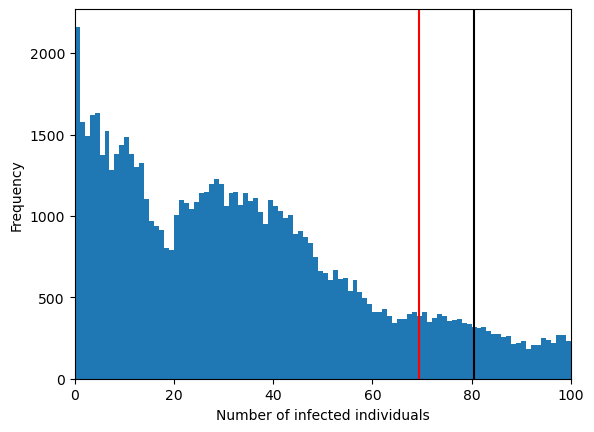

In [2]:
plt.hist(ttI, bins = np.arange(0, max(ttI)))
plt.xlim(0, 100)
plt.xlabel('Number of infected individuals')
plt.ylabel('Frequency')
plt.axvline(x = ((7 * mu)/(gamma + (7 * mu)))*(1 - (1/R0))*N0, color = 'black', label = 'axvline - full height')
plt.axvline(x = np.mean(ttI), color = 'red', label = 'axvline - full height')
plt.savefig('final plot')

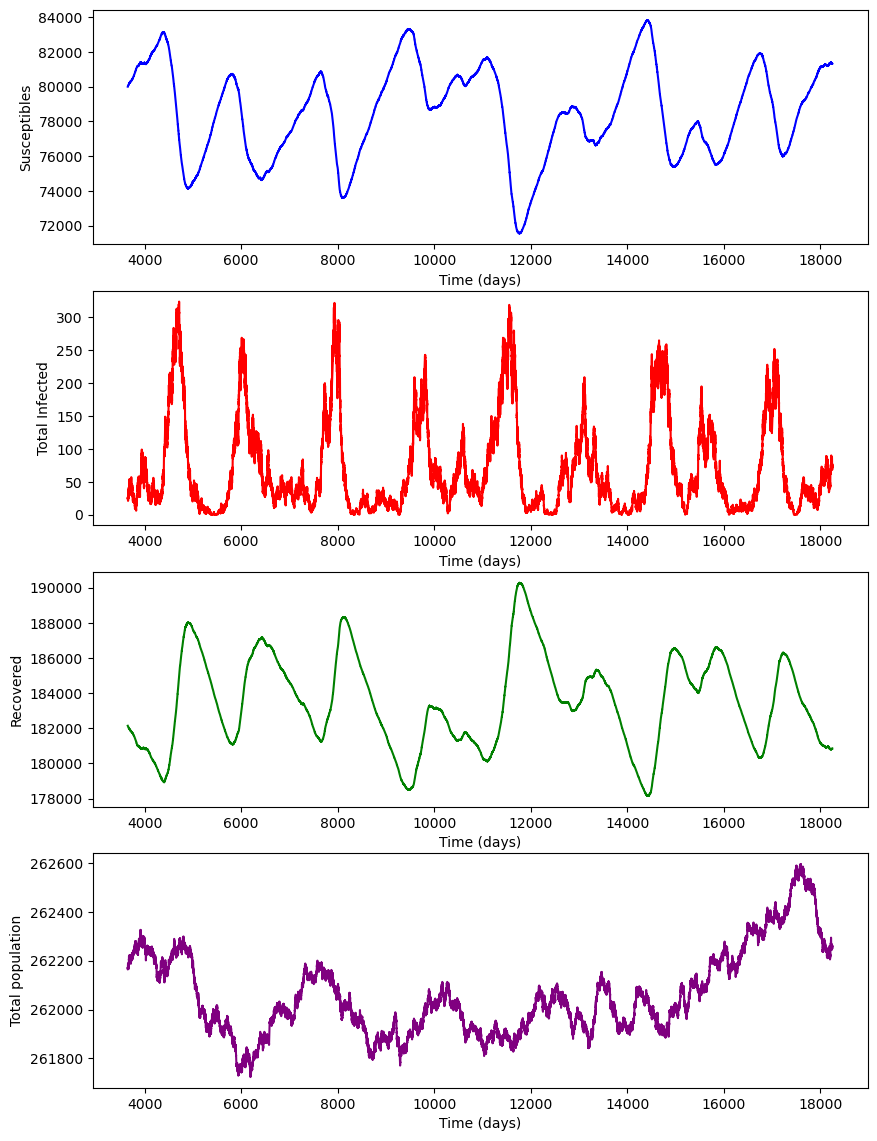

The disease went exinction at the points [12013, 12113, 12211, 12311, 12570, 12681, 12805, 32745, 32789, 32959, 33542, 39242, 39424, 61019, 61175, 61448, 61482, 61569, 61604, 71575, 71654, 72515, 72521, 72570, 72716, 80851, 87191, 96624, 96712, 96855]
Each extinction was for the corresponding time [22, 75, 58, 125, 93, 117, 222, 33, 161, 4, 57, 130, 16, 19, 39, 30, 46, 3, 112, 58, 31, 2, 16, 116, 21, 17, 65, 77, 134, 233]
There was a total of  262216  births.
and  262099  deaths
birth - deaths is therefore 117
and 1555  imports
there were [1966476.] events


In [3]:
figure(figsize=(10, 14))
plt.subplot(4, 1, 1)
plt.plot(tT, tS, 'b')
plt.xlabel ('Time (days)')
plt.ylabel ('Susceptibles')
plt.subplot(4, 1, 2)
plt.plot(tT, ttI, 'r')
plt.xlabel ('Time (days)')
plt.ylabel ('Total Infected')
#plt.subplot(4, 1, 3)
#plt.plot(tT, tI, lw='0.25')
#plt.ylabel ('Infected')
plt.subplot(4, 1, 3)
plt.plot(tT, tR, 'g')
plt.xlabel ('Time (days)')
plt.ylabel ('Recovered')
#plt.gcf().subplots_adjust(bottom=-0.15)
plt.subplot(4, 1, 4)
plt.plot(tT, tS+ttI+tR, 'purple')
plt.xlabel ('Time (days)')
plt.ylabel ('Total population')
plt.savefig('Tau 4 fig')
plt.show()

#code to calculate where the disease goes extinct and how long for
if np.size(zero_points) > 0:
    extinction_points = [zero_points[0]]
    extinction_lengths = []
    extinction_timer = 0
    for i in range(len(zero_points)-1):
        if zero_points[i] != zero_points[i+1] - 1:
            extinction_points.append(zero_points[i+1])
            extinction_lengths.append(extinction_timer)
            extinction_timer = 0
        else:
            extinction_timer += 1
    extinction_lengths.append(extinction_timer)
    print("The disease went exinction at the points", extinction_points)
    print("Each extinction was for the corresponding time", extinction_lengths)
    
print("There was a total of ", birth_toll, " births.")
print("and ", death_toll, " deaths")
print("birth - deaths is therefore", birth_toll - death_toll)
print("and", total_imports, " imports")
print("there were", process_toll, "events")

NameError: name 'v02' is not defined

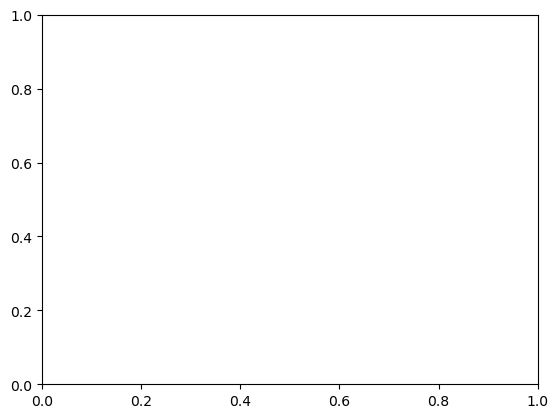

In [4]:
import matplotlib.animation as animation

fig, ax = plt.subplots()

line2 = ax.plot(tT[0], ttI[0], label=f'v0 = {v02} m/s')[0]
ax.set(xlim=[0, 3], ylim=[-4, 10], xlabel='Time [s]', ylabel='Z [m]')
ax.legend()


def update(frame):
    # update the line plot:
    line2.set_xdata(tT[:frame])
    line2.set_ydata(ttI[:frame])
    return (scat, line2)


ani = animation.FuncAnimation(fig=fig, func=update, frames=40, interval=30)
plt.show()

In [ ]:
print("In total we had", len(extinction_points), " extinction points")
print("And the mean time was", np.mean(extinction_lengths),)
print("We had infectious cases for", np.size(np.where(ttI > 0)), " points.")
print(np.size(np.where(ttI > 0))/len(extinction_points)/7)

In [ ]:
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
from matplotlib.ticker import ScalarFormatter
import matplotlib.cm as cm

def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    plt.scatter( x, y, s=4, c=z, cmap=cm.plasma, **kwargs,  )

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    #ax.set_yscale('log')
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap=cm.plasma), ax=ax)
    cbar.ax.set_ylabel('Density')
    plt.ylabel ('Total infected individuals')
    plt.xlabel ('Total susceptible individuals')
    plt.savefig('Tau scatter - R0 = 5, AvInf = 2')

    return ax


if "__main__" == __name__ :
    density_scatter( tS, ttI, bins = [30,30] )

In [ ]:
from scipy.fft import fft, fftfreq
import pywt
import pandas as pd
data = {
  "day": tT.tolist(),
  "susceptibles": tS.tolist(),
  "total infected": ttI.tolist(),
  "recovered": tR.tolist(),
}

In [ ]:
readme = open("readme.txt", "w")
readme.write(str([" gamma =", gamma,
" mu =", mu,
" Maximum time (ND) =", ND,
" Number_Infection_States =", Number_Infection_States,
" Average_Infectious_Period =", Average_Infectious_Period,
" R0 =", R0,
" beta =", beta,
" tau =", tau]))
readme.close()

In [ ]:
y=data["total infected"]-np.mean(data["total infected"])
N = len(y)
period = 182/N
x = tT
FFT_ttI = fft(y)

fig, ax = plt.subplots()

xf = 1/(N*period)*np.arange(N//2)
ax.set_yscale('log')
plt.ylim(bottom = 10**-4)
plt.xlabel('period (days)')
plt.ylabel('power spectrum')
plt.plot(xf, 365/N * np.abs(FFT_ttI[0:N//2]),'r')
#plt.axvline(x = xf[np.argmax(182/N * np.abs(FFT_ttI[0:N//182]))], color = 'black', label = 'axvline - full height')
plt.savefig('FFT of infected')
plt.show()





print(tau * xf[np.argmax(2.0/N * np.abs(FFT_ttI[0:N//2]))])
N = len(y)
period = 1/N
x = tT
FFT_ttI = fft(y)


fig, ax = plt.subplots()
xf = 1/(N*period)*np.arange(0, N//2)
print(xf)
ax.set_yscale('log')
plt.ylim(bottom = 10**-4, top = 10**2)
plt.xlabel('period (days)')
plt.ylabel('power spectrum')
plt.plot(tau * xf, 1/N * np.abs(FFT_ttI[0:N//2]),'.r')
plt.savefig('FFT of infected - big')
plt.show()
print(tau * xf[np.argmax(1/N * np.abs(FFT_ttI[0:N//2]))])

In [ ]:
y = data["susceptibles"]-np.mean(data["susceptibles"])
FFT_tS = fft(y)
fig, ax = plt.subplots()
xf = 1/(N*period)*np.arange(0, N//2)
print(xf)
ax.set_yscale('log')
plt.ylim(bottom = 10**-4, top = 10**2)
plt.xlabel('period (days)')
plt.ylabel('power spectrum')
plt.plot(xf * tau, 1/N * np.abs(FFT_tS[0:N//2]),'.b')
plt.savefig('FFT of susceptible - big')
plt.show()

In [ ]:
# perform CWT
wavelet = "cgau1"
widths = np.geomspace(1, 10*365, num=100)
sampling_period = tau # due to how Tau leap works any smaller sampling period would make no sense
cwtmatr, freqs = pywt.cwt(y, widths, wavelet, sampling_period=sampling_period)
# absolute take absolute value of complex result
cwtmatr = np.abs(cwtmatr[:-1, :-1])

In [ ]:
# plot result using matplotlib's pcolormesh (image with annoted axes)
fig, axs = plt.subplots(2, 1)
pcm = axs[0].pcolormesh(tT, 1/freqs, cwtmatr)
axs[0].set_yscale("log")
axs[0].set_xlabel("Time (Days)")
axs[0].set_ylabel("Frequency (Days$^{-1}$)")
axs[0].set_title("Continuous Wavelet Transform")
fig.colorbar(pcm, ax=axs[0])

periods = 1/freqs[1:,]

plt.loglog(periods, np.sum(np.asmatrix(cwtmatr), 1))
plt.axvline(x = periods[np.argmax(np.sum(np.asmatrix(cwtmatr), 1))], color = 'black', label = 'axvline - full height')
axs[1].set_xlabel("Period (Days)")
axs[1].set_ylabel("Power")
axs[1].set_title("Global wavelet spectrum")
plt.tight_layout()
plt.savefig('Wavelets and power')
plt.show()

In [ ]:
nonzero_points = np.where(ttI > 0)
nonzero_points = nonzero_points[0]
if np.size(nonzero_points) > 0:
    disease_points = [nonzero_points[0]]
    disease_lengths = []
    disease_timer = 0
    for i in range(len(nonzero_points)-1):
        if nonzero_points[i] != nonzero_points[i+1] - 1:
            disease_points.append(nonzero_points[i+1])
            disease_lengths.append(disease_timer)
            disease_timer = 0
        else:
            disease_timer += 1
    disease_lengths.append(disease_timer)
    print("The disease was reintroduced at the points", disease_points)
    print("Each disease run was for the corresponding time", disease_lengths)
    
from scipy.signal import argrelextrema
print(argrelextrema(ttI, np.greater))
    
print(periods[np.argmax(np.sum(np.asmatrix(cwtmatr), 1))])
print(np.mean(disease_lengths))

In [ ]:
# plot fourier transform for comparison
from numpy.fft import rfft, rfftfreq

yf = rfft(ttI)
xf = rfftfreq(len(ttI), sampling_period)
print(sampling_period)
#xf = 1/(N*period)*np.arange(N//2)
plt.semilogy(xf, np.abs(yf), '.r')
plt.xlabel("Frequency (Days$^{-1}$)")
axs[1].set_title("Fourier Transform")
plt.tight_layout()
plt.show()

Now we're going to use erf to find the proportion of the time our disease spend extinct. First this will be done via my the data generated in this file, and then via plugging in our parameters to a formula detailed in the main body of the dissertation

In [ ]:
from scipy.special import erf

one_or_less_points = np.where(ttI <= 1)

#print(beta)
#print(mu)
#print(R0)
#print(gamma)
#print(Average_Infectious_Period)
R0 = 5

I_equil_theory = ((7 * mu)/(gamma + (7 * mu)))*(1 - (1/R0))
I_equil_theory_var = (((R0 - 1)/N0) + (7*mu*(1+R0))/(N0*(R0**2)*(gamma + 7*mu))) #((7*mu*(R0 - 1 + (1/R0))/(gamma + (7*mu))) + ((1/R0)-1))

print("Our theoretical value for I* is ", I_equil_theory)
print("Our theoretical value for the variance from I* is ", I_equil_theory_var)
print("Our mean total infection point is", np.mean(ttI)/N0)
print("Our mean variance of total infections", np.var(ttI/N0))
print("Using erf with our means values and variance taken from the model data we find our disease is extinct", 100 * (0.5 + 0.5*erf(-np.mean(ttI/N0)/np.sqrt(2*np.var(ttI/N0)))),"% of the time")
print("Using a basic proportion method we find our disease is extinct", 100 * (len(zero_points)/len(tT)),"% of the time")
print("Using erf along with our analytical calculations for variance and mean around I at equilibirum gives us that the disease is extinct",
      100 * (0.5 + 0.5*erf(-I_equil_theory/np.sqrt(2*I_equil_theory_var))),"% of the time")

In [ ]:
eigen_poly = [1, ((mu*R0) + (2*mu) + (gamma/4) + (gamma/3)), mu*R0*((2*mu)+(gamma/4)+(gamma/3)), mu*(R0 - 1)*(mu + (gamma / 4))*(mu + (gamma / 3))]
print(np.roots(eigen_poly))

In [ ]:
print(pywt.wavelist(kind='continuous'))

In [ ]:
for i in pywt.wavelist(kind='continuous'):
    # perform CWT
    wavelet = i
    print(i)
    # logarithmic scale for scales, as suggested by Torrence & Compo:
    widths = np.geomspace(1, 10*365, num=100)
    sampling_period = np.diff(tT).mean()
    cwtmatr, freqs = pywt.cwt(ttI, widths, wavelet, sampling_period=sampling_period)
    # absolute take absolute value of complex result
    cwtmatr = np.abs(cwtmatr[:-1, :-1])
    
    # plot result using matplotlib's pcolormesh (image with annoted axes)
    fig, axs = plt.subplots(2, 1)
    pcm = axs[0].pcolormesh(tT, 1/freqs, cwtmatr)
    axs[0].set_yscale("log")
    axs[0].set_xlabel("Time (Days)")
    axs[0].set_ylabel("Frequency (Days$^{-1}$)")
    axs[0].set_title("Continuous Wavelet Transform")
    fig.colorbar(pcm, ax=axs[0])

    plt.loglog(1/freqs[1:,], np.sum(np.asmatrix(cwtmatr), 1))
    axs[1].set_xlabel("Period (Days)")
    axs[1].set_ylabel("Power")
    axs[1].set_title("Global wavelet spectrum")
    plt.tight_layout()
    plt.savefig('Wavelets and power')
    plt.show()

In [ ]:
x = np.arange(0.001, 10, 0.00001)
y = 1 - ((mu/((1/7)+mu))*((1/(x**2))+(2/(x**3))))
plt.ylim(-5, 5)
plt.grid()
plt.plot(x, y)
#poly = [(mu+(gamma/7))/mu, 0, -1, -2]
#print(np.roots(poly))
#x + (mu*(1+x))/((x**2)*((1/7)+mu)) - 1
print(1 - ((mu/((1/7)+mu))*((1/(1**2))+(2/(1**3)))))